![img](LineMask_get_position.png)

In [1]:
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

from IPython.display import display

class LineMask:
    def __init__(self, mask, bar_class):
        self.mask = np.load(mask)
        self.bar_class = json.load(open(bar_class))

    def get_position(self, bbox):
        """
        bbox: [x1, y1, x2, y2]
        return: group, measure, staff 
        """
        x1, y1, x2, y2 = list(map(int, bbox))
        bbox_mask = self.mask[y1:y2, x1:x2,:4]
        point = [x1, y1]
        if np.max(bbox_mask) == 0:
            x = int((x2 + x1) / 2)
            y = int((y2 + y1) / 2)
            for i in range(1,500):
                if self.mask[y-i, x, 0] != 0:
                    y = y - i
                    break
                if self.mask[y+i, x, 0]!= 0:
                    y = y + i
                    break
            point = [y, x]
        else:
            point = np.argwhere(bbox_mask[:,:,0] != 0)[0]
            point[0] = point[0] + y1
            point[1] = point[1] + x1
        return self.mask[point[0], point[1], 0], self.mask[point[0], point[1], 3], self.mask[point[0], point[1], 1]

    def get_pitch_position(self, class_id, bbox):
        """
        class_id: 类别
        bbox: [x1, y1, x2, y2]
        return: group, measure, staff, line, offset

        line  线
            最上方的第五线 为 0
            向下+1
            向上-1

        offset  符头与线的相对位置
            0:线在上，符头在下
            1:线在中间,符头在线中
            2:线在下，符头在上

        """
        x1, y1, x2, y2 = list(map(int, bbox))
        if int(class_id) in [1,2,3,4,38]:
            y1 = y1 - (y2-y1)/2.5
            y2 = y2 + (y2-y1)/2.5
        elif int(class_id) in [36, 37, 41, 42]:
            y1 = y1 + (y2-y1)/10
            y2 = y2 - (y2-y1)/10
        elif int(class_id) in [35, 39, 40]:
            y1 = y1 + (y2-y1)/3
            y2 = y2 + (y2-y1)/6
            
        # 沿y轴三等分
        bbox1 = list(map(int, [x1, y1, x2, y1+(y2-y1)/3]))
        bbox2 = list(map(int, [x1, y1+(y2-y1)/3, x2, y1+(y2-y1)*2/3]))
        bbox3 = list(map(int, [x1, y1+(y2-y1)*2/3, x2, y2]))

        bbox_mask1 = self.mask[bbox1[1]:bbox1[3], bbox1[0]:bbox1[2],:4] # 上位置
        bbox_mask2 = self.mask[bbox2[1]:bbox2[3], bbox2[0]:bbox2[2],:4] # 中间位置
        bbox_mask3 = self.mask[bbox3[1]:bbox3[3], bbox3[0]:bbox3[2],:4] # 下位置
        
        point = list(map(int, [y1, x1]))
        offset = 0
        bbox_mask = self.mask
        if np.max(bbox_mask2) != 0:
            point = np.argwhere(bbox_mask2[:,:,0]!= 0)[0]
            offset = 1
            bbox_mask = bbox_mask2
        elif np.max(bbox_mask1)!= 0:
            point = np.argwhere(bbox_mask1[:,:,0]!= 0)[0]
            offset = 0
            bbox_mask = bbox_mask1
        elif np.max(bbox_mask3)!= 0:
            point = np.argwhere(bbox_mask3[:,:,0]!= 0)[0]
            offset = 2
            bbox_mask = bbox_mask3
        else:
            position = list(map(int, self.get_position(bbox)))
            print(f"error: {point} group: {position[0]}, measure: {position[1]}, staff: {position[2]}")

        return bbox_mask[point[0], point[1], 0], bbox_mask[point[0], point[1], 3],\
        bbox_mask[point[0], point[1], 1], bbox_mask[point[0], point[1], 2], offset

    def get_beam_ids(self, bbox):
        """
        bbox: [x1, y1, x2, y2]
        return: beam_ids : []
        0: 表示背景, 只有0表示没有beam
        """
        x1, y1, x2, y2 = list(map(int, bbox))
        # y1 = int(y1 - (y2-y1)/7)
        # y2 = int(y2 + (y2-y1)/7)
        bbox_mask = self.mask[y1:y2, x1:x2, 4]
        beam_ids = np.unique(bbox_mask)
        beam_ids = beam_ids[beam_ids != 0]
        return beam_ids
        
    def readTxtToYolo(self, txtpath):
        retdata = []
        with open(txtpath, 'r', encoding='utf-8') as f:
            for line in f.readlines():
                line = line.strip().split(' ')
                yolo_box = map(float, line)
                retdata.append(list(yolo_box))
            f.close()
            return np.array(retdata)
LM = LineMask("../mask_int8.npy","../bar_class.json")

DF_INFO_LABEL = pd.read_csv("info_label.tsv",sep="\t")
LABEL_IDS = {
    "clef":DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("clef"),"label"].to_list(),
    "notehead" :DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("notehead"),"label"].to_list(),
"whole_notehead":DF_INFO_LABEL.loc[
    DF_INFO_LABEL["type"].str.contains("notehead") & DF_INFO_LABEL["type"].str.contains("whole",case=False),
    "label"
].to_list(),
"stem_notehead" :DF_INFO_LABEL.loc[
    DF_INFO_LABEL["type"].str.contains("notehead") & ~DF_INFO_LABEL["type"].str.contains("whole",case=False)
    ,"label"
    ].to_list(),
    "rest":DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("rest"),"label"].to_list(),
}
print(LABEL_IDS)

def show_df(df,n = 2):
    display(df.head(n),df.shape)
def plt_imshow(img):
    plt.close("all")
    with plt.rc_context({
        "figure.dpi":250,
        "xtick.bottom":False,
        "xtick.labelbottom":False,
        "ytick.left":False,
        "ytick.labelleft":False
    }):
        plt.imshow(img[:,:,::-1])
        plt.show()

def create_Element(tag,text=None,attrs=None):
    ele = ET.Element(tag,attrib= attrs if attrs else {})
    if text:
        ele.text = text
    return ele
def assemble_multiple_elements(root,elements):
    """
    将多个元素组装到一个根元素下
    root elements

    root E1

    or
    
    root [E1,E2,E3]

    """
    if isinstance(elements,ET.Element):
        root.append(elements)
    else:
        for i in range(len(elements)):
            if isinstance(elements[i],ET.Element):
                root.append(elements[i])
            else:
                assert i - 1 >= 0 and isinstance(elements[i - 1],ET.Element),\
                    "can not append elements[{}] to elemts[{}]\n\telements[{}] = {}".format(
                        i,i-1,i,elements[i]
                    )
                assemble_multiple_elements(elements[i-1],elements[i])
    return root

def show_obj_attr(obj,func_filter = lambda s: not s.startswith("_")):
    return [ i for i in  dir(obj) if func_filter(i)]


df_label = pd.read_csv("../label_in_image.txt",sep=" ",header = None)
df_label.columns = "class_id,cx,cy,w,h,pos".split(",")
for k in "cx,cy,w,h".split(","):
    df_label[k] = df_label[k].round().astype(np.int64)

df_label["x1"] = df_label.eval("cx - w / 2").round().astype(np.int64)
df_label["y1"] = df_label.eval("cy - h / 2").round().astype(np.int64)
df_label["x2"] = df_label.eval("cx + w / 2").round().astype(np.int64)
df_label["y2"] = df_label.eval("cy + h / 2").round().astype(np.int64)
df_label["row,measure,staff".split(",")] = df_label.apply(lambda row:
               LM.get_position((
                   row["x1"],row["y1"],row["x2"],row["y2"]
                   ))
               ,axis=1).apply(pd.Series)
df_label["line"] = 0
df_label["offset"] = 0

show_df(df_label)

img_source = cv2.imread("../396751092-316810cb-c02d-415b-84bf-408c2e03d914.png")
img_source = cv2.resize(img_source, (2560, 3840))

{'clef': [12, 13], 'notehead': [1, 2, 3, 4], 'whole_notehead': [3, 4], 'stem_notehead': [1, 2], 'rest': [14, 15, 16, 17, 18, 19, 20, 21, 22]}


,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
0,12,230,3163,53,161,0.972951,204,3082,256,3244,5,1,1,0,0
1,13,337,906,57,77,0.969918,308,868,366,944,1,1,2,0,0


(803, 15)

# 选择一部分 一个staff

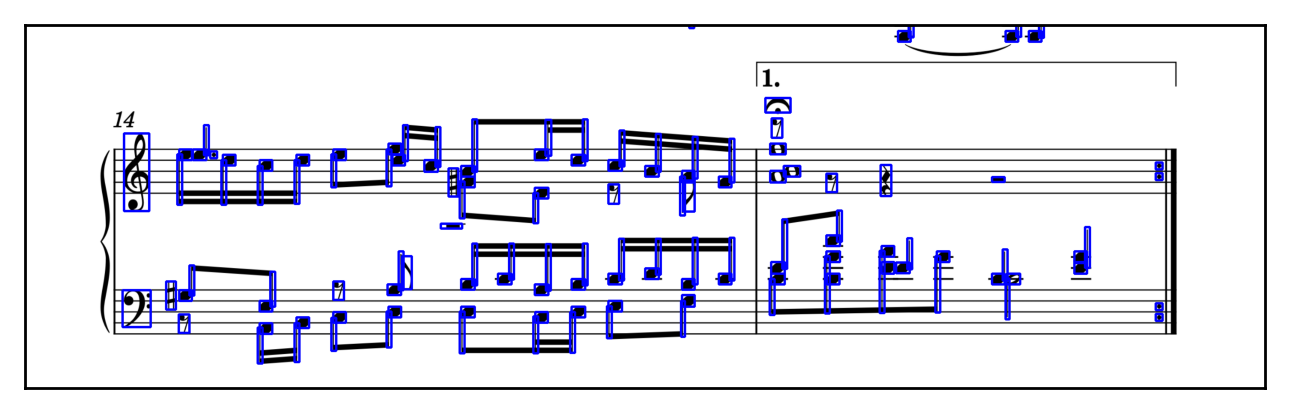

In [2]:
# df_label = df_label.query("row == 4 & measure == 1 & staff == 2")
df_label = df_label.sort_values(["cx","cy"]).reset_index(drop=True)

img = img_source.copy()
for row in df_label.itertuples():
    cv2.rectangle(img,(row.x1,row.y1),
                  (row.x2,row.y2),(255,0,0),3)
plt_imshow(img[2200:2950,:])
# plt_imshow(img)

# 符杆和符梁 联合为 NOTEBLOCK

In [3]:
df_stem = df_label.query("class_id == 5").copy()
df_stem["beam_ids"] = df_stem.apply(lambda row:
              LM.get_beam_ids((row["x1"],row["y1"],row["x2"],row["y2"])),
              axis=1)
show_df(df_stem,5)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids
22,5,319,2520,10,103,0.838576,314,2468,324,2572,4,1,1,0,0,"[53, 54]"
23,5,321,3159,10,108,0.815741,316,3105,326,3213,5,1,1,0,0,[79]
38,5,344,2728,10,62,0.848996,339,2697,349,2759,4,1,2,0,0,[62]
39,5,346,3031,10,64,0.840233,341,2999,351,3063,5,1,1,0,0,[]
40,5,346,3464,10,165,0.861674,341,3382,351,3546,5,1,2,0,0,[]


(239, 16)

In [4]:
class BEAM:
    def __init__(self,id,start,end=None):
        self.id = id
        self.start = start
        self.end = end
    def set_end(self,end):
        self.end = end

    def __repr__(self):
        return "BEAM {} ({},{})".format(self.id,self.start,self.end)

class NOTEBLOCK:
    def __init__(self,stem_id = None,beam_id = None):
        # self.note_ids = [] # 暂不处理
        self.beams = {} # stem_id
        self.stem_ids = set()
        if stem_id:
            self.append_stem(stem_id)
            if beam_id:
                self.append_beam(beam_id,stem_id)
    def __repr__(self):
        return "NOTEBLOCK\n\tstem {stems}\n\tbeams {beams}\n".format(
            stems = ','.join([str(i) for i in self.stem_ids]),
            beams = ','.join([str(i) for i in self.beams.keys()])
            )

    def append_stem(self,stem_id):
        self.stem_ids.add(stem_id)

    def append_beam(self,beam_id,stem_id):
        """
        若beam_id不存在于self.beams
        stem_id作为start    用于创建BEAM
        否则stem_id作为end  用于更新BEAM
        """
        self.append_stem(stem_id)
        if beam_id in self.beams.keys():
            self.beams[beam_id].set_end(stem_id)
        else:
            self.beams[beam_id] = BEAM(beam_id,stem_id)

    def get_box(self,df_label):
        data = df_label.loc[list(self.stem_ids),:]
        return data["x1"].min(),data["y1"].min(),data["x2"].max(),data["y2"].max()

    def get_beams(self):
        return self.beams

class NOTEBLOCK_MANAGER:
    """
    管理一个staff 内的 NOTEBLOCK
    """
    def __init__(self):
        # self.map_beam_to_nb = {}
        self.map_beam_to_stem = {} # k 符梁id value 起始符杆id
        self.nbs = {} # k 起始符杆id

    def find_noteblock(self,beam_ids):
        """
        map_beam_to_stem将起始stem一致的beam视为一组
        无法处理下方的bad case

        find_noteblock可处理bad case并返回该组的起始stem
        若无则返回None

        OK 以起始steam为key
        |   |   |
        |---|   |
        |   |   |
        |---|---|

        bad case  短线与长线的起始steam不同
        |   |   |
        |   |---|
        |   |   |
        |---|---|

        """
        for beam_id in beam_ids:
            if beam_id in self.map_beam_to_stem.keys():
                return self.map_beam_to_stem[beam_id]
        return None

    def append(self,stem_id,beam_ids):
        stem_start = self.find_noteblock(beam_ids)
        if stem_start:
            self.map_beam_to_stem.update({beam_id:stem_start for beam_id in beam_ids})
            nb = self.nbs[stem_start]
            for beam_id in beam_ids:
                            nb.append_beam(beam_id,stem_id)
        else:
            self.map_beam_to_stem.update({beam_id:stem_id for beam_id in beam_ids})
            nb = NOTEBLOCK(stem_id)
            for beam_id in beam_ids:
                nb.append_beam(beam_id,stem_id)
            self.nbs[stem_id] = nb

    # dict-like
    def keys(self):
        return self.nbs.keys()
    def values(self):
        return self.nbs.values()
    def items(self):
        return self.nbs.items()

nb_manager = NOTEBLOCK_MANAGER()
for stem_id,row in df_stem.iterrows():
    nb_manager.append(stem_id,row["beam_ids"])

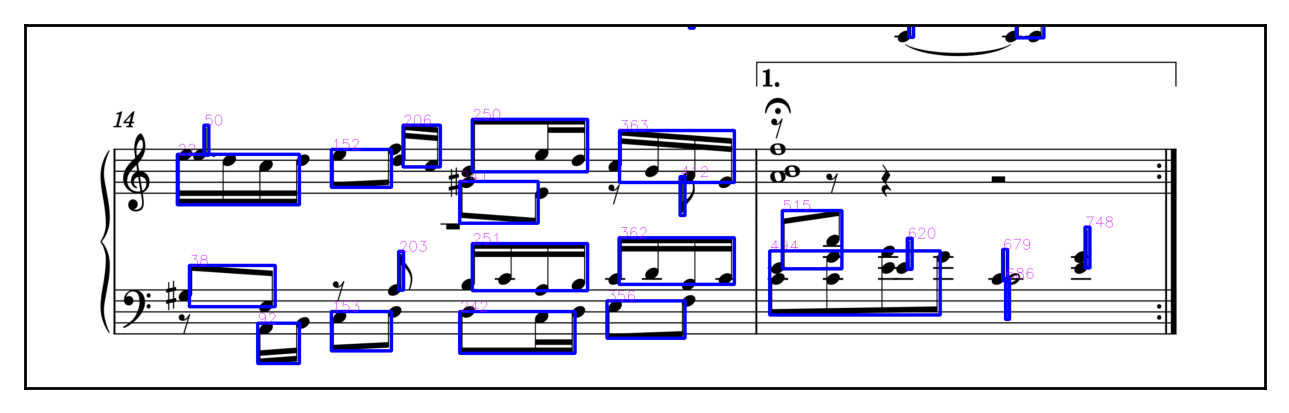

In [5]:
img = img_source.copy()
for i,nb in nb_manager.nbs.items():
    box = nb.get_box(df_label)
    cv2.rectangle(img,box[:2],box[2:],(255,0,0),5)
    cv2.putText(img,str(i),box[:2],
                # cv2.FONT_HERSHEY_SIMPLEX,
                cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                1,(255,0,200)
                )
plt_imshow(img[2200:2950,:])
# plt_imshow(img)

# 纳入休止符 和 全符头

> 休止符


In [6]:
df_rest = df_label[df_label["class_id"].isin(LABEL_IDS["rest"])]
show_df(df_rest)
class RESTBLOCK:
    def __init__(self,id):
        self.id = id
    def get_box(self,df_label):
        return df_label.at[self.id,"x1"],df_label.at[self.id,"y1"],\
            df_label.at[self.id,"x2"],df_label.at[self.id,"y2"]
    def __repr__(self):
        return "RESTBLOCK  {}".format(self.id)

class RESTBLOCK_MANAGER:
    def __init__(self,ids = None):
        self.rbs = {id:RESTBLOCK(id) for id in ids}

    def append(self,id):
        self.rbs[id] = RESTBLOCK(id)

    # dict-like
    def keys(self):
        return self.rbs.keys()
    def values(self):
        return self.rbs.values()
    def items(self):
        return self.rbs.items()

    def __repr__(self):
        return "RESTBLOCK_MANAGER\n\t{}".format(",".join([str(i) for i in self.rbs.keys()]))

rb_manager = RESTBLOCK_MANAGER(df_rest.index.to_list())
# rb_manager.rbs[4].get_box(df_label)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
24,18,328,2817,22,39,0.897522,317,2798,339,2836,4,1,2,0,0
93,17,490,1548,21,64,0.866312,480,1516,500,1580,2,1,2,0,0


(46, 15)

> 全符头

全音符头和双权符头，没有符杆


In [7]:
class WHOLENOTEHEADBLOCK:
    def __init__(self,id):
        self.id = id
    def get_box(self,df_label):
        return df_label.at[self.id,"x1"],df_label.at[self.id,"y1"],\
            df_label.at[self.id,"x2"],df_label.at[self.id,"y2"]
    def __repr__(self):
        return "WHOLENOTEHEAD  {}".format(self.id)

class WHOLENOTEHEAD_MANAGER:
    def __init__(self,ids = None):
        self.wnbs = {id:RESTBLOCK(id) for id in ids}

    def append(self,id):
        self.wnbs[id] = RESTBLOCK(id)
    
    # dict-like
    def keys(self):
        return self.wnbs.keys()
    def values(self):
        return self.wnbs.values()
    def items(self):
        return self.wnbs.items()

    def __repr__(self):
        return "WHOLENOTEHEAD_MANAGER\n\t{}".format(",".join([str(i) for i in self.wnbs.keys()]))

df_whole =  df_label[df_label["class_id"].isin(LABEL_IDS["whole_notehead"])]

wnh_manager =  WHOLENOTEHEAD_MANAGER(df_whole.index.to_list())
wnh_manager

WHOLENOTEHEAD_MANAGER
	70,71,74,78,183,503,504,520

# 符头符杆匹配

有符头不一定有符杆,但有符杆必有符头

而且符头还有共用的情况

符头可以确定音高

**距离**： L1 距离即可，L2距离浪费计算资源

> 距离最短之前还得过滤

![img](./符头符杆匹配_badcase_01.png)


**尚未考虑多符头的情况(和弦)**

要不然再使用符杆找符头之后

剩下的，尚未分配的符头找各自最近的符杆吧（特别是多符头的情况）

分两步，将所有符头分配给符杆


> 效果还不错

![img](./符头符杆匹配_result.png)

In [8]:
def find_notehead(df_stem,df_notehead):
    """
    为stem寻找notehead

    分两步：
        1. find_single_notehead_for_stem
            为符杆找符头  适用于1根stem对应一个notehead
        2. find_single_stem_for_notehead
            为剩下的符头找符杆  处理1根stem对应多个notehead
    合并

     df_stem
        新增列 df_stem["notehead_ids"]
    """
    def find_single_notehead_for_stem(x1,y1,x2,y2,df_notehead):
        """
        符杆找符头，一个符杆找一个符头
        
        寻找符杆外侧的最近一个符头
        """
        cx = np.int16(x1+(x2-x1)/2)
        cy = np.int16(y1+(y2-y1)/2)

        # notehead 的上边缘 超出 stem的上边缘
        # notehead 的下边缘 超出 stem的下边缘 
        df_notehead = df_notehead[(y1 > df_notehead["y1"] ) | (y2 <df_notehead["y2"])]
        # | cy - cy | + | cx - cx |
        pesudo_distance = (cx - df_notehead["cx"]).abs() + (cy - df_notehead["cy"]).abs()
        return pesudo_distance.idxmin()

    def find_single_stem_for_notehead(cx,cy,df_stem):
        """
        符头找符杆
        在find_notehead符杆找符头之后
        没有被分配的符头(二分符头和全黑符头)寻找各自的符杆
        即寻找和弦的其他符头

        每个符头找一个符杆
        后于符杆表中汇总
        """
        persudo_distance = (df_stem["cx"] - cx).abs() + (df_stem["cy"] - cy).abs()
        return persudo_distance.idxmin()

    notehead_ids = df_stem.apply(lambda row:find_single_notehead_for_stem(
                        row["x1"],row["y1"],
                        row["x2"],row["y2"],df_notehead),
                        axis=1)

    df_notehead_mutil = df_notehead[
        # 未分配的符头
        ~df_notehead.index.isin(notehead_ids) & \
        # 非 全 符头 （有符杆的）
        df_notehead["class_id"].isin(LABEL_IDS["stem_notehead"])
        ]

    stem_ids = df_notehead_mutil.apply(lambda row:find_single_stem_for_notehead(
        row["cx"],row["cy"],df_stem),axis=1)

    # 汇总
    notehead_ids = notehead_ids.apply(lambda x:[x])
    for i,ids in stem_ids.groupby(stem_ids).apply(lambda df:df.index.to_list()).items():
        notehead_ids.at[i] += ids
    df_stem["notehead_ids"] = notehead_ids
    return df_stem

df_notehead = df_label[df_label["class_id"].isin(LABEL_IDS["notehead"])]

df_stem = find_notehead(df_stem,df_notehead)

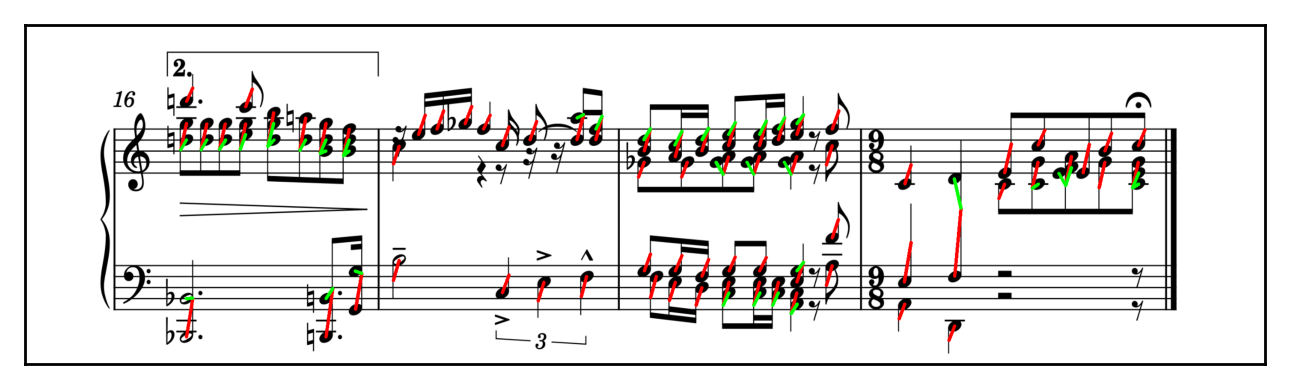

In [9]:
img = img_source.copy()
for row in df_stem.itertuples():
    for i,notehead_id in enumerate(row.notehead_ids):
        cv2.line(img,(row.cx,row.cy),
                (df_notehead.at[notehead_id,"cx"],
                df_notehead.at[notehead_id,"cy"]),
                (0,0,255) if i == 0 else (0,255,0),5)
plt_imshow(img[2900:3600,:])

In [10]:
show_df(df_stem)
show_df(df_notehead)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids,notehead_ids
22,5,319,2520,10,103,0.838576,314,2468,324,2572,4,1,1,0,0,"[53, 54]",[27]
23,5,321,3159,10,108,0.815741,316,3105,326,3213,5,1,1,0,0,[79],"[33, 34]"


(239, 17)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
27,1,331,2469,27,23,0.902044,318,2458,344,2480,4,1,1,0,0
28,1,331,2759,27,23,0.916370,318,2748,344,2770,4,1,2,0,0


(319, 15)